In [1]:
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
from IPython.display import display, Markdown
from sklearn.calibration import calibration_curve
from sklearn.calibration import CalibratedClassifierCV
from scipy.special import logit
from sklearn.linear_model import LogisticRegression

import sys
sys.path.append('../')

import utils
from evalutils.roc import get_bootstrapped_roc_ci_curves
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## directory where results are
EXPERIMENT_DIR = f"/data/bodyct/experiments/lung-malignancy-fairness-shaurya"
NLST_PREDS = f"{EXPERIMENT_DIR}/nlst"

TEAMS_DIR = "C:/Users/shaur/OneDrive - Radboudumc/Documents - Master - Shaurya Gaur/General/Malignancy-Estimation Results"
NLST_PREDS = f"{TEAMS_DIR}/nlst" ## Comment out if not using Teams backup (aka Chansey is up :)

In [2]:
def make_calibration_plots(labels, raw_outputs, calibrated_outputs, title=""):
    """
    Make the calibration curves or the reliability diagrams to show how well calibrated a classifier is

    Parameters
    ----------
    labels: array of binary labels
    raw_outputs: array of confidences between 0-1 (uncalibrated)
    calibrated_outputs: array of confidences between 0-1 (calibrated)
    title: additional title describing the dataset for which the calibration curve is being plotted

    Returns
    -------
    figure with plots

    """

    figure = plt.figure(figsize=(5, 5), constrained_layout=True)

    colors = sns.color_palette("colorblind")

    # Platt's scaling

    fraction_of_positives, mean_predicted_value = calibration_curve(
        labels, calibrated_outputs, n_bins=10
    )
    plt.scatter(mean_predicted_value, fraction_of_positives)
    plt.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label="DL algorithm after Platt's scaling",
        color=colors[4],
    )

    # uncalibrated

    fraction_of_positives, mean_predicted_value = calibration_curve(
        labels, raw_outputs, n_bins=10
    )
    plt.plot(
        mean_predicted_value,
        fraction_of_positives,
        "s-",
        label="DL algorithm",
        color=colors[0],
    )

    plt.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")

    plt.title(
        f"Calibration plots (reliability curves)" + title,
        # fontsize=8,
    )
    plt.grid()
    plt.ylabel("Fraction of positives")
    plt.xlabel("Predicted probability")
    plt.ylim([0, 1])
    plt.xlim([0, 1])
    plt.legend(loc="lower right")
    plt.xticks(np.arange(0, 1.1, 0.1))
    plt.yticks(np.arange(0.1, 1.1, 0.1))

    return figure

## DLCST preds

In [3]:
dlcst_preds = pd.read_csv(f"{TEAMS_DIR}/dlcst/dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", header=0)
dlcst_preds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   PatientID            599 non-null    int64  
 1   StudyDate            599 non-null    int64  
 2   SeriesInstanceUID    599 non-null    object 
 3   Age                  599 non-null    int64  
 4   Sex                  599 non-null    int64  
 5   FamilyHistoryLungCa  599 non-null    int64  
 6   Emphysema            599 non-null    int64  
 7   NoduleCountPerScan   599 non-null    int64  
 8   sybil_year1          599 non-null    float64
 9   sybil_year2          599 non-null    float64
 10  sybil_year3          599 non-null    float64
 11  sybil_year4          599 non-null    float64
 12  sybil_year5          599 non-null    float64
 13  sybil_year6          599 non-null    float64
 14  PanCan2b             599 non-null    float64
 15  Ensemble_Kiran       599 non-null    flo

In [4]:
dlcst_models = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

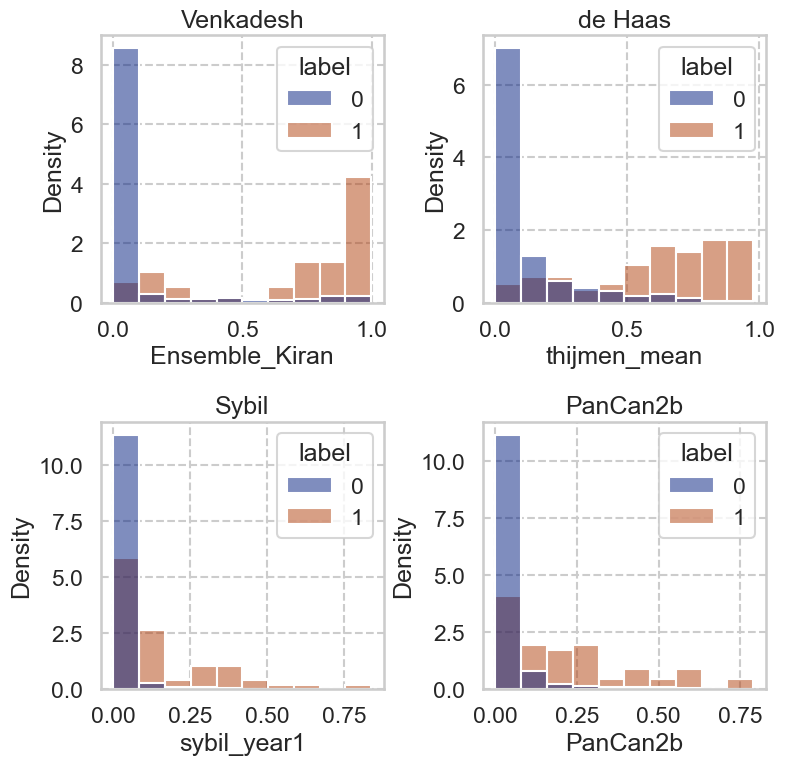

In [5]:
fig, ax = plt.subplots(2, len(dlcst_models) // 2, figsize=(8, 8))
ax = ax.flatten()

for i, m in enumerate(dlcst_models):
    sns.histplot(data=dlcst_preds, ax=ax[i], x=dlcst_models[m], hue='label', common_norm=False, stat='density', bins=10)
    ax[i].set_title(f'{m}')

# plt.legend(title='Label', loc='upper right', labels=['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

In [6]:
dlcst_calibrate = {
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
}

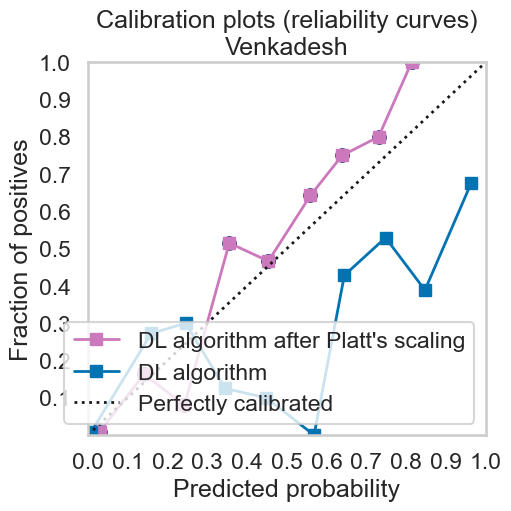

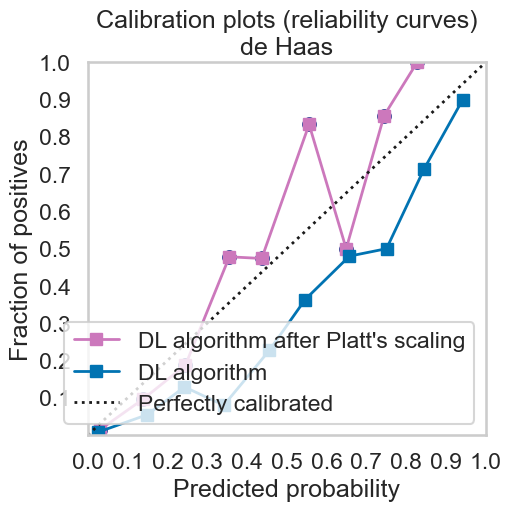

In [7]:
for m in dlcst_calibrate:
    # read the csv file containing raw predictions on the full NLST set using 10-fold CV
    logits = logit(dlcst_preds[dlcst_calibrate[m]].values)
    labels = dlcst_preds['label'].values

    # build and fit a Logistic Regression model to calibrate the DL algorithm's outputs
    clf = CalibratedClassifierCV(estimator=LogisticRegression(), cv=10)
    clf.fit(logits.reshape(-1, 1), labels)
    calibrated_outputs = clf.predict_proba(logits.reshape(-1, 1))[:, 1]
    dlcst_preds[f'{dlcst_calibrate[m]}_cal'] = calibrated_outputs

    fig = make_calibration_plots(dlcst_preds['label'], dlcst_preds[dlcst_calibrate[m]], dlcst_preds[f'{dlcst_calibrate[m]}_cal'], title=f'\n{m}')
    plt.show(fig)

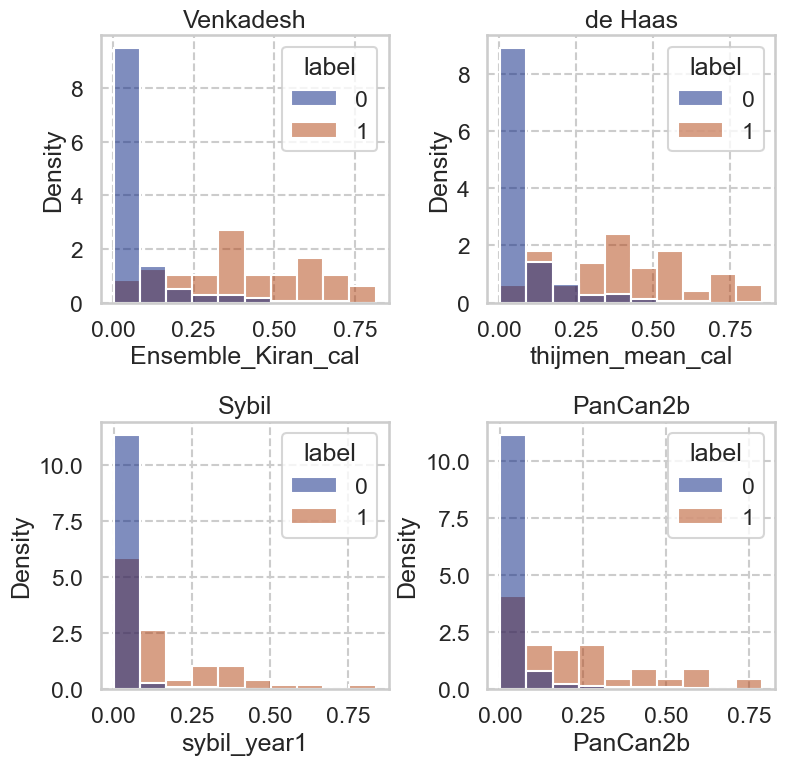

In [8]:
dlcst_calibrated = {
    "Venkadesh": "Ensemble_Kiran_cal",
    "de Haas": "thijmen_mean_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b",
}

fig, ax = plt.subplots(2, len(dlcst_calibrated) // 2, figsize=(8, 8))
ax = ax.flatten()

for i, m in enumerate(dlcst_calibrated):
    sns.histplot(data=dlcst_preds, ax=ax[i], x=dlcst_calibrated[m], hue='label', common_norm=False, stat='density', bins=10)
    ax[i].set_title(f'{m}')

# plt.legend(title='Label', loc='upper right', labels=['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

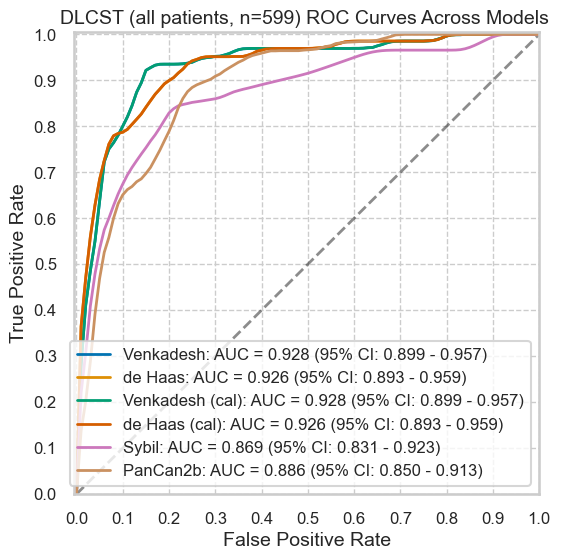

In [9]:
utils.rocs_models(dlcst_preds, models={
    "Venkadesh": "Ensemble_Kiran",
    "de Haas": "thijmen_mean",
    "Venkadesh (cal)": "Ensemble_Kiran_cal",
    "de Haas (cal)": "thijmen_mean_cal",
    "Sybil": "sybil_year1",
    "PanCan2b": "PanCan2b", 
}, dataset_label="DLCST")

In [10]:
dlcst_preds.to_csv(f"{TEAMS_DIR}/dlcst/calibrated_dlcst_thijmen_kiran_sybil_malignancy_estimation_results.csv", index=False)

## NLST predictions

In [11]:
nlst_preds_nodule = pd.read_csv(f"{NLST_PREDS}/nlst_demov3_allmodels.csv")
nlst_preds_nodule.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Columns: 103 entries, PatientID to BMI
dtypes: bool(10), float64(78), int64(11), object(4)
memory usage: 11.6+ MB


In [12]:
models = {
    "Venkadesh": "DL",
    "de Haas Combined": "Thijmen_mean",
    "de Haas Local": "Thijmen_local",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "PanCan2b": "PanCan2b",
    "Sybil year 1": "sybil_year1",
    "Sybil year 2": "sybil_year2",
    "Sybil year 3": "sybil_year3",
    "Sybil year 4": "sybil_year4",
    "Sybil year 5": "sybil_year5",
    "Sybil year 6": "sybil_year6",
}

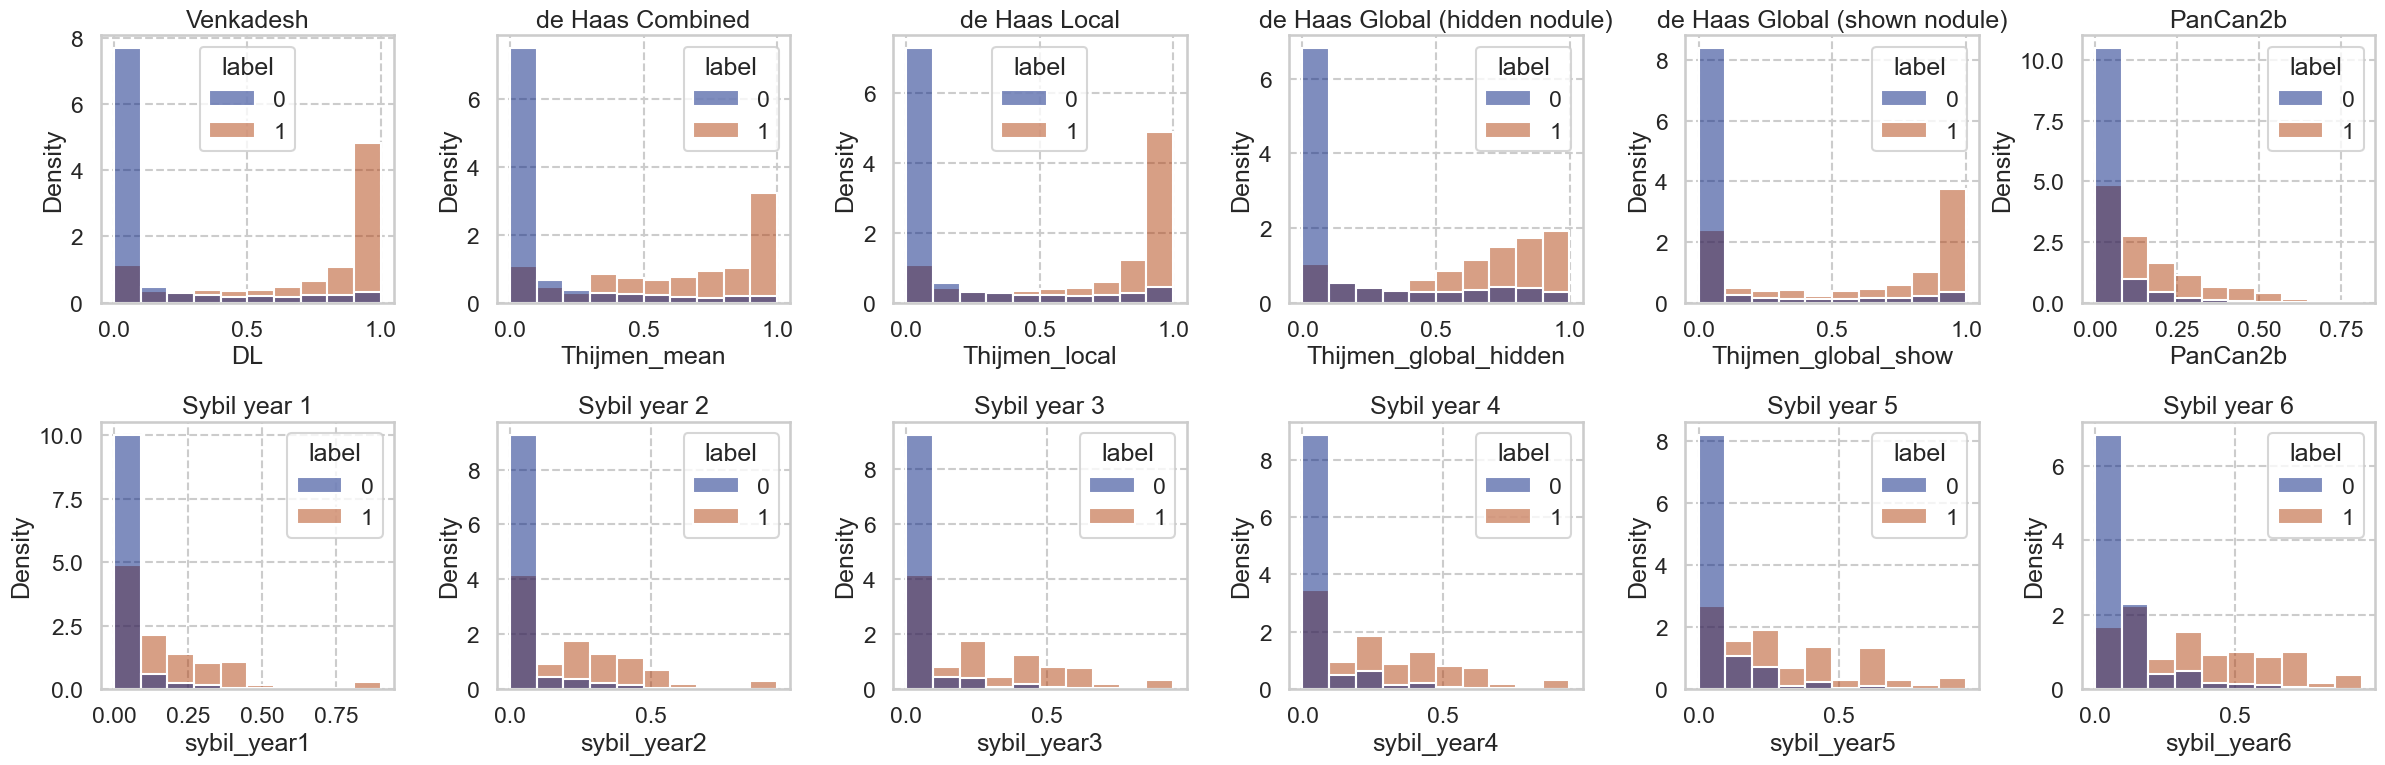

In [13]:
fig, ax = plt.subplots(2, len(models) // 2, figsize=(24, 8))
ax = ax.flatten()

for i, m in enumerate(models):
    sns.histplot(data=nlst_preds_nodule, ax=ax[i], x=models[m], hue='label', common_norm=False, stat='density', bins=10)
    ax[i].set_title(f'{m}')

# plt.legend(title='Label', loc='upper right', labels=['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

In [14]:
models_to_calibrate = {
    "Venkadesh": "DL",
    # "de Haas Combined": "Thijmen_mean", ## Do this separately, since less data?
    "de Haas Local": "Thijmen_local",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (shown nodule)": "Thijmen_global_show", 
}

In [15]:
nlst_preds_nodule[list(models_to_calibrate.values())].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   DL                     16077 non-null  float64
 1   Thijmen_local          16077 non-null  float64
 2   Thijmen_global_hidden  16077 non-null  float64
 3   Thijmen_global_show    16077 non-null  float64
dtypes: float64(4)
memory usage: 502.5 KB


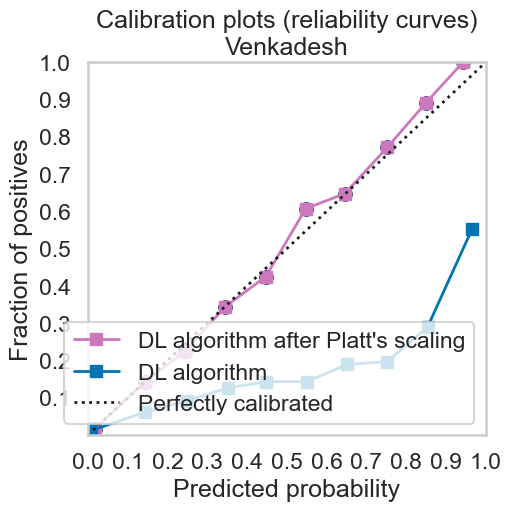

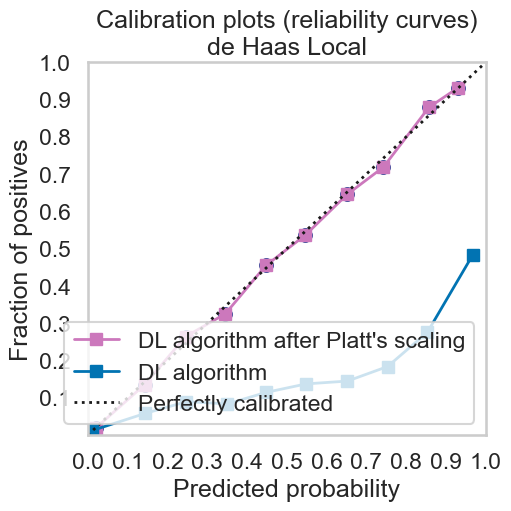

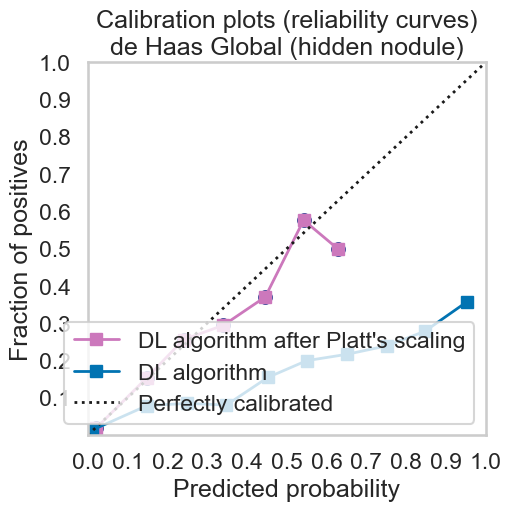

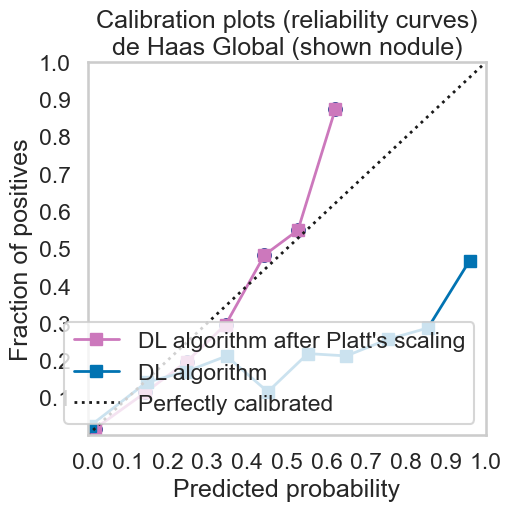

In [16]:
for m in models_to_calibrate:
    # read the csv file containing raw predictions on the full NLST set using 10-fold CV
    logits = logit(nlst_preds_nodule[models[m]].values)
    labels = nlst_preds_nodule['label'].values

    # build and fit a Logistic Regression model to calibrate the DL algorithm's outputs
    clf = CalibratedClassifierCV(estimator=LogisticRegression(), cv=10)
    clf.fit(logits.reshape(-1, 1), labels)
    calibrated_outputs = clf.predict_proba(logits.reshape(-1, 1))[:, 1]
    nlst_preds_nodule[f'{models[m]}_cal'] = calibrated_outputs

    fig = make_calibration_plots(nlst_preds_nodule['label'], nlst_preds_nodule[models[m]], nlst_preds_nodule[f'{models[m]}_cal'], title=f'\n{m}')
    plt.show(fig)

Calibrate Tijmen's combined model separately since it has fewer predictions.

In [17]:
nlst_tijmen = utils.prep_nlst_preds(nlst_preds_nodule, scanlevel=False, tijmen=True, sybil=False)
nlst_tijmen.nunique().sort_values(ascending=False)

AnnotationID         3240
Thijmen_mean         3240
DL                   3239
Thijmen_local_cal    3239
Thijmen_local        3239
                     ... 
HighSchoolPlus          2
canctran                1
canclung                1
cancnasa                1
cancpanc                1
Length: 107, dtype: int64

In [18]:
nlst_tijmen = nlst_tijmen[['AnnotationID', 'label', 'Thijmen_mean']]
nlst_tijmen

,AnnotationID,label,Thijmen_mean
7664,100012_1_19990102,1,8.066968e-01
7665,100012_1_20000102,1,8.966099e-01
7671,100069_1_20000102,0,7.221026e-11
7672,100069_1_20010102,0,7.296459e-13
7673,100069_2_20000102,0,1.071313e-10
...,...,...,...
16069,218857_1_20000102,0,2.112545e-02
16070,218857_1_20010102,0,3.985039e-02
16074,218862_1_19990102,0,3.870139e-01
16075,218862_1_20000102,0,2.125442e-02


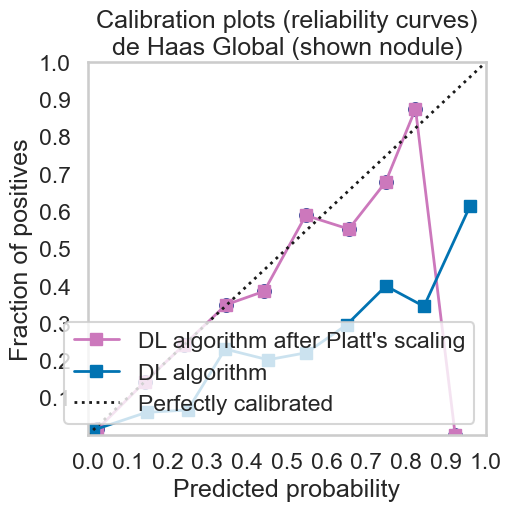

In [19]:
logits = logit(nlst_tijmen['Thijmen_mean'].values)
labels = nlst_tijmen['label'].values

# build and fit a Logistic Regression model to calibrate the DL algorithm's outputs
clf = CalibratedClassifierCV(estimator=LogisticRegression(), cv=10)
clf.fit(logits.reshape(-1, 1), labels)
calibrated_outputs = clf.predict_proba(logits.reshape(-1, 1))[:, 1]
nlst_tijmen[f'Thijmen_mean_cal'] = calibrated_outputs

fig = make_calibration_plots(nlst_tijmen['label'], nlst_tijmen['Thijmen_mean'], nlst_tijmen[f'Thijmen_mean_cal'], title=f'\n{m}')
plt.show(fig)

In [20]:
nlst_preds_all = nlst_preds_nodule.merge(nlst_tijmen, 
                how="left", ## 'inner' for only ones Thijmen has preds for
                on=['AnnotationID', 'Thijmen_mean', 'label'], suffixes=(None,None))

In [21]:
nlst_preds_all[list(models.values()) + [f"{m}_cal" for m in models_to_calibrate.values()] + ['Thijmen_mean_cal']].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16077 entries, 0 to 16076
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DL                         16077 non-null  float64
 1   Thijmen_mean               3240 non-null   float64
 2   Thijmen_local              16077 non-null  float64
 3   Thijmen_global_hidden      16077 non-null  float64
 4   Thijmen_global_show        16077 non-null  float64
 5   PanCan2b                   16077 non-null  float64
 6   sybil_year1                9543 non-null   float64
 7   sybil_year2                9543 non-null   float64
 8   sybil_year3                9543 non-null   float64
 9   sybil_year4                9543 non-null   float64
 10  sybil_year5                9543 non-null   float64
 11  sybil_year6                9543 non-null   float64
 12  DL_cal                     16077 non-null  float64
 13  Thijmen_local_cal          16077 non-null  flo

In [22]:
calibrated_models = {
    "Venkadesh": "DL_cal",
    "de Haas Combined": "Thijmen_mean_cal",
    "de Haas Local": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden_cal",
    "de Haas Global (shown nodule)": "Thijmen_global_show_cal",
    "PanCan2b": "PanCan2b",
    "Sybil year 1": "sybil_year1",
    "Sybil year 2": "sybil_year2",
    "Sybil year 3": "sybil_year3",
    "Sybil year 4": "sybil_year4",
    "Sybil year 5": "sybil_year5",
    "Sybil year 6": "sybil_year6",
}

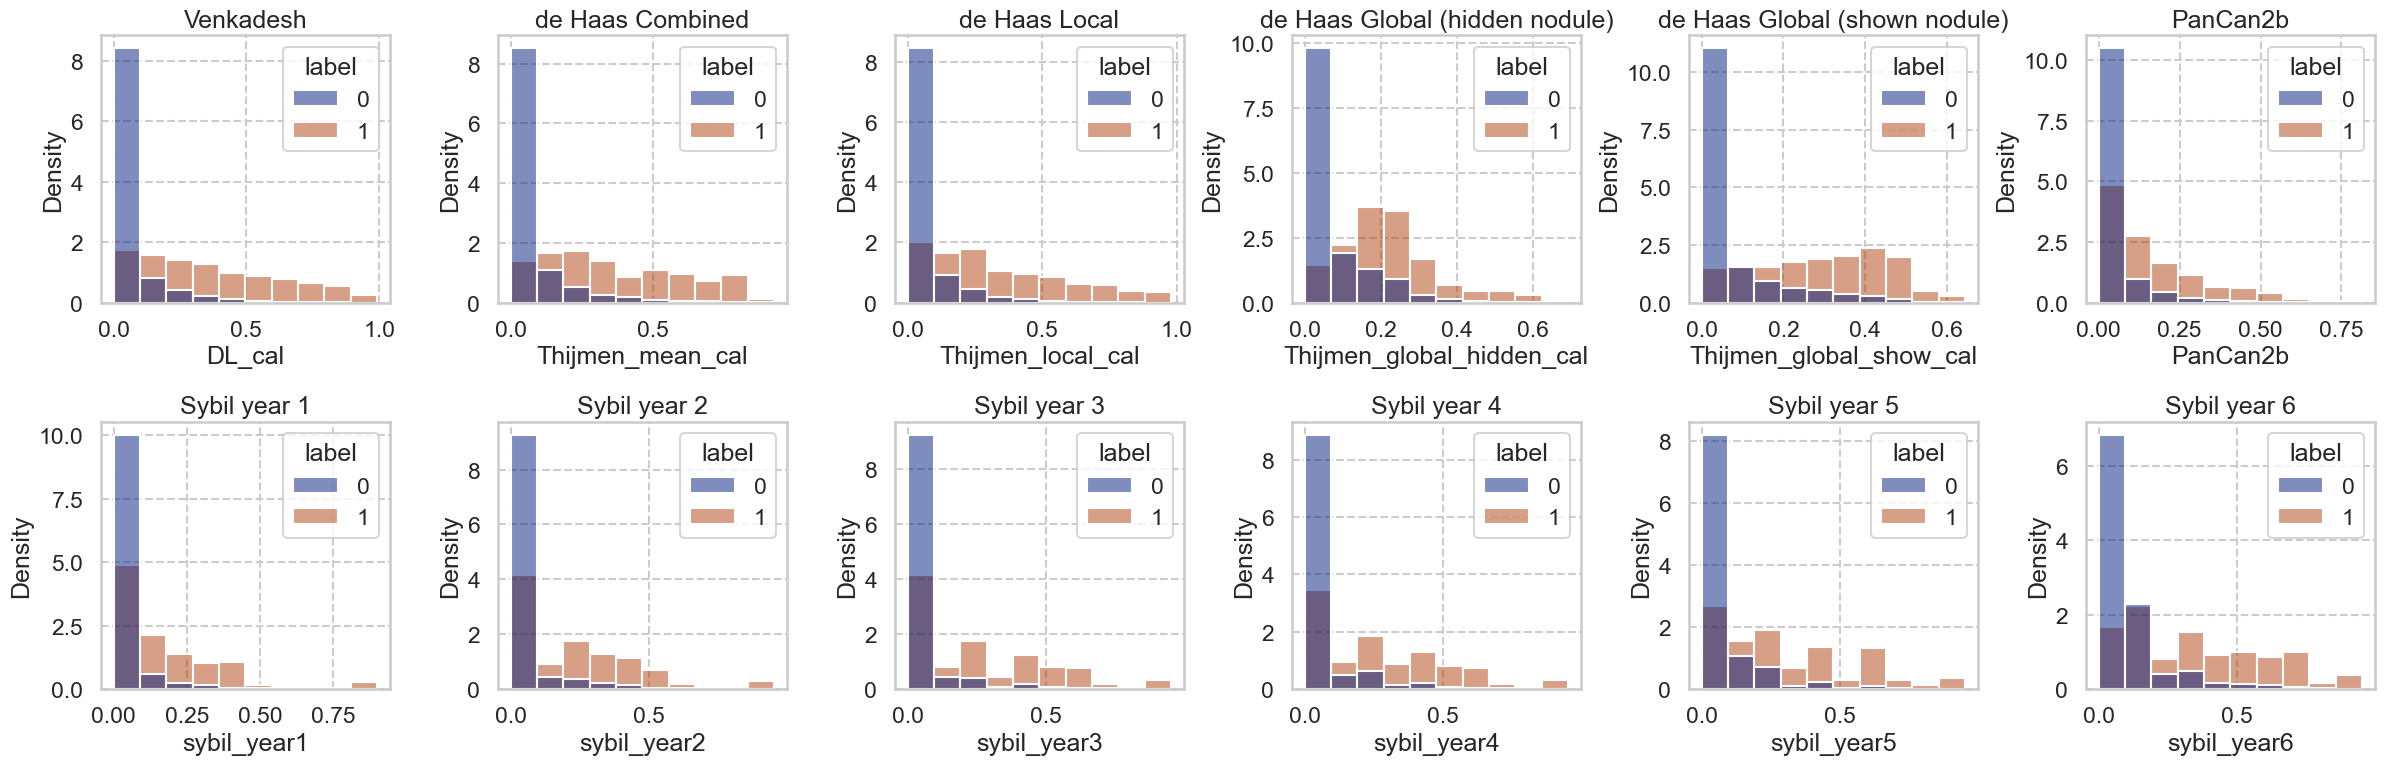

In [23]:
fig, ax = plt.subplots(2, len(calibrated_models) // 2, figsize=(24, 8))
ax = ax.flatten()

for i, m in enumerate(calibrated_models):
    sns.histplot(data=nlst_preds_all, ax=ax[i], x=calibrated_models[m], hue='label', common_norm=False, stat='density', bins=10)
    ax[i].set_title(f'{m}')

# plt.legend(title='Label', loc='upper right', labels=['Benign', 'Malignant'])
plt.tight_layout()
plt.show()

In [24]:
nlst_preds_all[list(models.values()) + [f"{m}_cal" for m in models_to_calibrate.values()] + ['Thijmen_mean_cal']]

,DL,Thijmen_mean,Thijmen_local,Thijmen_global_hidden,Thijmen_global_show,PanCan2b,sybil_year1,sybil_year2,sybil_year3,sybil_year4,sybil_year5,sybil_year6,DL_cal,Thijmen_local_cal,Thijmen_global_hidden_cal,Thijmen_global_show_cal,Thijmen_mean_cal
0,0.720335,NaN,0.919277,0.011265,4.384295e-01,0.090782,0.033887,0.063308,0.088700,0.104172,0.113203,0.157796,0.218318,0.302789,0.030685,0.231420,NaN
1,0.000528,NaN,0.000555,0.000006,1.409943e-12,0.006208,0.000000,0.000000,0.000000,0.000000,0.000817,0.001118,0.005858,0.005667,0.002004,0.001354,NaN
2,0.001523,NaN,0.004728,0.000001,5.031182e-10,0.004957,0.000000,0.001574,0.002951,0.004896,0.005621,0.014409,0.009224,0.014016,0.001199,0.003395,NaN
3,0.004533,NaN,0.035113,0.445484,8.545117e-05,0.004265,0.001784,0.005733,0.010996,0.015721,0.021112,0.034103,0.014795,0.033067,0.141252,0.033014,NaN
4,0.004670,NaN,0.031574,0.196405,1.643584e-03,0.006071,0.003951,0.015674,0.025373,0.034919,0.043507,0.063896,0.014989,0.031576,0.093208,0.062095,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16072,0.000110,NaN,0.002956,0.489399,1.622257e-02,0.007695,NaN,NaN,NaN,NaN,NaN,NaN,0.003022,0.011485,0.150003,0.102411,NaN
16073,0.000302,NaN,0.005616,0.515237,2.356248e-04,0.007395,NaN,NaN,NaN,NaN,NaN,NaN,0.004624,0.015079,0.155340,0.040909,NaN
16074,0.001564,0.387014,0.425352,0.455236,1.182241e-04,0.098142,NaN,NaN,NaN,NaN,NaN,NaN,0.009329,0.113658,0.143166,0.035349,0.173441
16075,0.000008,0.021254,0.002357,0.479522,1.780837e-08,0.005094,NaN,NaN,NaN,NaN,NaN,NaN,0.001017,0.010435,0.148003,0.006291,0.034600


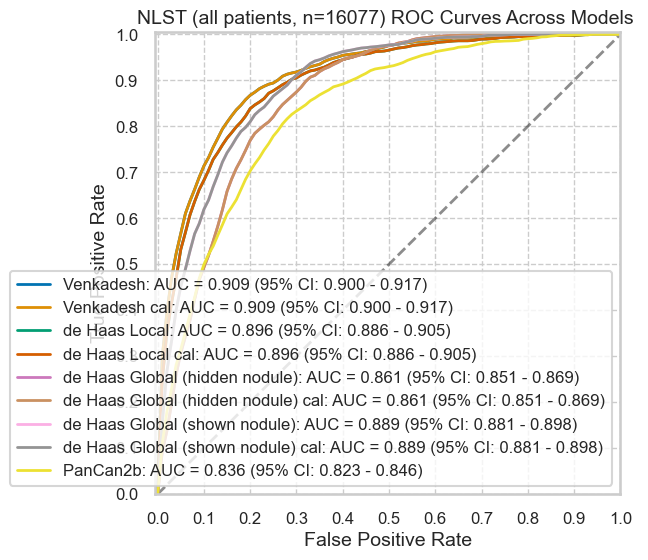

In [28]:
utils.rocs_models(nlst_preds_all, models={
    "Venkadesh": "DL",
    "Venkadesh cal": "DL_cal",
    # "de Haas Combined": "Thijmen_mean",
    "de Haas Local": "Thijmen_local",
    "de Haas Local cal": "Thijmen_local_cal",
    "de Haas Global (hidden nodule)": "Thijmen_global_hidden",
    "de Haas Global (hidden nodule) cal": "Thijmen_global_hidden_cal",
    "de Haas Global (shown nodule)": "Thijmen_global_show",
    "de Haas Global (shown nodule) cal": "Thijmen_global_show_cal",
    "PanCan2b": "PanCan2b",
    # "Sybil year 1": "sybil_year1",
    # "Sybil year 2": "sybil_year2",
    # "Sybil year 3": "sybil_year3",
    # "Sybil year 4": "sybil_year4",
    # "Sybil year 5": "sybil_year5",
    # "Sybil year 6": "sybil_year6",
}, dataset_label="NLST")

In [67]:
nlst_preds_all.to_csv(f"{NLST_PREDS}/nlst_demov3_allmodels_cal.csv", index=False)